In [ ]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [1]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

,Price,neg_oil,neu_oil,pos_oil,compound_oil,neg_war,neu_war,pos_war,compound_war
Date,,,,,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.000,0.000,0.0000,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.086,0.816,0.098,0.9796,0.144,0.708,0.147,-0.1356


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,271.0,82.667343,5.567707,71.839996,78.139999,82.739998,86.355000,96.550003
neg_oil,271.0,0.023033,0.024112,0.000000,0.000000,0.017500,0.038271,0.116000
neu_oil,271.0,0.496814,0.361231,0.000000,0.000000,0.604750,0.831000,0.960000
pos_oil,271.0,0.064340,0.055087,0.000000,0.000000,0.062000,0.100667,0.181000
compound_oil,271.0,0.378112,0.429797,-0.955900,0.000000,0.270900,0.950900,0.999900
neg_war,271.0,0.082097,0.071262,0.000000,0.013000,0.073000,0.132375,0.272500
neu_war,271.0,0.802173,0.128576,0.000000,0.773586,0.817200,0.854250,1.000000
pos_war,271.0,0.104691,0.065619,0.000000,0.066000,0.118000,0.139875,0.435000
compound_war,271.0,0.163507,0.595739,-0.999900,-0.357750,0.115525,0.701659,0.986600


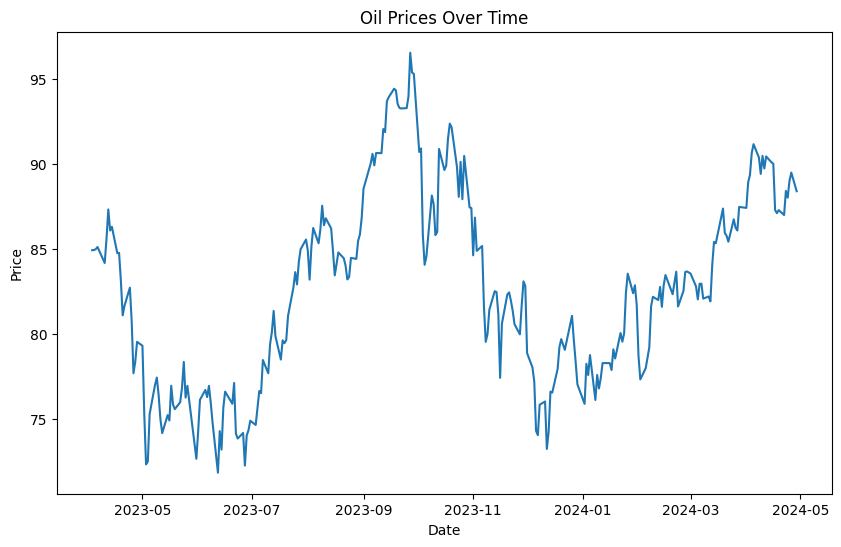

In [6]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [7]:
column_indices = {name: i for i, name in enumerate(data.columns)}
column_indices

{'Price': 0,
 'neg_oil': 1,
 'neu_oil': 2,
 'pos_oil': 3,
 'compound_oil': 4,
 'neg_war': 5,
 'neu_war': 6,
 'pos_war': 7,
 'compound_war': 8}

In [8]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
oil_data = data[['Price', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
# oil_data = data[['Price']]
oil_data.head()

,Price,neg_war,neu_war,pos_war,compound_war
Date,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.144,0.708,0.147,-0.1356


In [9]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))
# oil_data = scaler.fit_transform(oil_data)

C:\Users\wgras\AppData\Local\Temp\ipykernel_4688\1558082071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))


In [10]:
n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.875)]
test_df = oil_data[int(n*0.875):]

In [11]:
test_df

,Price,neg_war,neu_war,pos_war,compound_war
Date,,,,,
2024-03-12,0.407932,0.071857,0.851857,0.076143,0.179357
2024-03-13,0.493323,0.036273,0.807909,0.155818,0.705418
2024-03-14,0.549575,0.108250,0.792000,0.099500,-0.081150
2024-03-15,0.546337,0.100200,0.755400,0.144600,0.096620
2024-03-18,0.609065,0.057000,0.798000,0.144750,0.526450
2024-03-19,0.628895,0.097000,0.817200,0.086000,-0.166800
2024-03-20,0.571024,0.098500,0.777750,0.123750,0.429700
2024-03-21,0.564144,0.055833,0.812833,0.131333,0.495367
2024-03-22,0.549980,0.070000,0.777400,0.152400,0.194400


In [12]:
len(train_df),len(val_df),len(test_df)

(189, 48, 34)

In [13]:
train_df.columns

Index(['Price', 'neg_war', 'neu_war', 'pos_war', 'compound_war'], dtype='object')

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
def plot(self, model=None, plot_col='Price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [19]:
val_performance = {}
performance = {}
histories={}
models_list={}
windows_list={}

windows_dictionary = {
    'weekly': 7, 
    'bi-weekly': 14, 
    'monthly': 30, 
}


In [20]:
for w in windows_dictionary:
    input_width=windows_dictionary[w]
    window = WindowGenerator(
        input_width=input_width, label_width=1, shift=1,
        label_columns=['Price']
    )
    windows_list[w]=window

In [21]:
windows_list

{'weekly': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'bi-weekly': Total window size: 15
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 Label indices: [14]
 Label column name(s): ['Price'],
 'monthly': Total window size: 31
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29]
 Label indices: [30]
 Label column name(s): ['Price']}

In [22]:
windows_list['monthly']

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [23]:
MAX_EPOCHS = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

def compile_and_fit(model, window, patience=4):
  model.compile(
    loss='mean_absolute_percentage_error',
    optimizer='adam',
    metrics=[
      tf.keras.metrics.MeanAbsolutePercentageError(),
      tf.keras.metrics.MeanSquaredError()
    ]
  )

  history = model.fit(
    window.train, 
    epochs=MAX_EPOCHS, 
    validation_data=window.val,
    callbacks=[early_stopping,reduce_lr]
  )

  return history

1. Linear model

In [24]:
train_df.shape

(189, 5)

In [25]:
window=windows_list['monthly']
seq_length=30
input_shape=(seq_length, train_df.shape[1])
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [26]:
input_shape

(30, 5)

In [27]:
window.label_columns_indices

{'Price': 0}

In [28]:
def get_linear_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1, input_shape=input_shape)
    ])
    
    return model

In [29]:
def get_dense_model(input_shape):
    input = keras.Input(shape=input_shape)

    layer_1 = Dense(units=64, activation='relu')(input)
    layer_2 = Dense(units=32, activation='relu')(layer_1)
    layer_3 = Dense(units=8, activation='relu')(layer_2)
    output = Dense(units=1, activation='relu')(layer_3)

    model=keras.Model(input, output)

    return model


In [30]:

def get_conv_model(input_shape):
    input = keras.Input(shape=input_shape)

    layer_1 = Conv1D(
        filters=32,
        kernel_size=input_shape[0],
        activation='relu',
        padding='same')(input)
    layer_1 = layers.MaxPooling1D()(layer_1)
    layer_1 = Flatten()(layer_1)
    layer_2 = Dense(units=32, activation='relu')(layer_1)
    layer_3 = Dense(units=8, activation='relu')(layer_2)
    output = Dense(units=1, activation='relu')(layer_3)

    model=keras.Model(input, output)

    return model

    # model = tf.keras.Sequential([
    #     tf.keras.layers.Conv1D(filters=32,
    #                         kernel_size=(input_shape[0],),
    #                         activation='relu'),
    #     tf.keras.layers.Dense(units=32, activation='relu'),
    #     tf.keras.layers.Dense(units=1),
    # ])

In [31]:

def get_lstm_model_1(input_shape):
    # 3. Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model

In [32]:

def get_lstm_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(units=60, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [33]:

def get_lstm_model_3(input_shape):
    input = keras.Input(shape=input_shape)

    layer = LSTM(units=60, return_sequences=True)(input)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=50, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=40, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=20, return_sequences=False)(layer)
    layer = Dropout(0.2)(layer)
    output = Dense(units=1)(layer)

    model=keras.Model(input, output)

    # model = Sequential()
    # model.add(LSTM(units=60, return_sequences=True, input_shape=input_shape))
    # model.add(Dropout(0.2))
    # model.add(LSTM(units=50, return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(units=40, return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(units=30, return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(units=20, return_sequences=False))
    # model.add(Dropout(0.2))
    # model.add(Dense(units=1))

    return model

In [34]:

def get_bidirectional_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=20, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=20, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=10, return_sequences=False)))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [35]:
# 3. Build the Transformer model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
d_model = 64
num_heads = 4
ff_dim = 64
num_transformer_blocks = 4
rate = 0.1

def build_transformer_model(input_shape, d_model, num_heads, ff_dim, num_transformer_blocks, rate=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(d_model)(inputs)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(d_model, num_heads, ff_dim, rate)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(rate)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def get_transformer_model(input_shape):
    model = build_transformer_model(
    input_shape, 
    d_model, 
    num_heads, 
    ff_dim, 
    num_transformer_blocks,
    rate
)

    return model

In [36]:
def get_ensemble_model(input_shape):
    model1 = get_dense_model(input_shape)
    model2 = get_dense_model(input_shape)
    model3 = get_dense_model(input_shape)

    inputs = keras.Input(shape=input_shape)
    y1 = model1(inputs)
    y2 = model2(inputs)
    y3 = model3(inputs)
    outputs = layers.average([y1, y2, y3])
    ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
    return ensemble_model

In [37]:
def get_ensemble_model2(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    transformer_model = get_transformer_model(input_shape)
    lstm_model = get_lstm_model_3(input_shape)
    convolution_model = get_conv_model(input_shape)

    y1 = transformer_model(inputs)
    y2 = lstm_model(inputs)
    y3 = convolution_model(inputs)
    
    ensemble_model=layers.concatenate([y1, y2, y3])
    layer_1 = Dense(units=64, activation='relu')(ensemble_model)
    layer_2 = Dense(units=32, activation='relu')(layer_1)
    layer_3 = Dense(units=8, activation='relu')(layer_2)
    outputs = Dense(units=1, activation='relu')(layer_3)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

Epoch 1/100
5/5 [==============================] - 25s 1s/step - loss: 890701.3125 - mean_absolute_percentage_error: 890701.3125 - mean_squared_error: 0.2193 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000 - val_mean_squared_error: 0.1981 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 168ms/step - loss: 99.3711 - mean_absolute_percentage_error: 99.3711 - mean_squared_error: 0.2517 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000 - val_mean_squared_error: 0.1981 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 274ms/step - loss: 99.3711 - mean_absolute_percentage_error: 99.3711 - mean_squared_error: 0.2517 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000 - val_mean_squared_error: 0.1981 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 1s 291ms/step - loss: 99.3711 - mean_absolute_percentage_error: 99.3711 - mean_squared_error: 0.2517 - val_loss: 100.0000 - val_mean_absolute_per

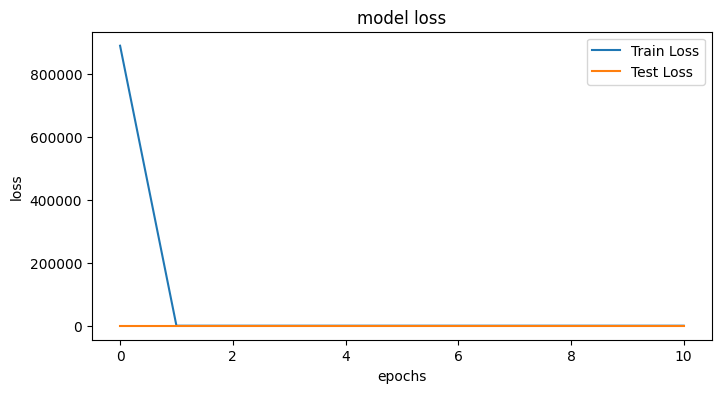

In [38]:
# linear = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=1, input_shape=input_shape)
# ])

linear=get_ensemble_model2(input_shape)

history = compile_and_fit(linear, window)

histories_Linear = history
val_performance_Linear = linear.evaluate(window.val, return_dict=True)
performance_Linear = linear.evaluate(window.test, verbose=1, return_dict=True)

# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(histories_Linear.history['loss'], label='Train Loss')
plt.plot(histories_Linear.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
# plt.savefig('outputs/reddit oil + war - lstm model 01 model loss.png')
plt.show()

In [39]:
models_name_list={
    'linear_model' : get_linear_model ,
    'dense_model' : get_dense_model ,
    'conv_model' : get_conv_model ,
    'lstm_model_1' : get_lstm_model_1 ,
    'lstm_model_2' : get_lstm_model_2 ,
    'lstm_model_3' : get_lstm_model_3 ,
    'bidirectional_lstm_model' : get_bidirectional_lstm_model ,
    'transformer_model' : get_transformer_model ,
    'ensemble_model' : get_ensemble_model ,
    'ensemble_model_2' : get_ensemble_model2 ,
}
models_list={}

In [40]:
for model_type in models_name_list:
    print(model_type)

linear_model
dense_model
conv_model
lstm_model_1
lstm_model_2
lstm_model_3
bidirectional_lstm_model
transformer_model
ensemble_model
ensemble_model_2


In [41]:
def create_model_for_each_model_type(model_type):
    for window_name in windows_dictionary:
        seq_length=windows_dictionary[window_name]
        window = windows_list[window_name]
        input_shape=(seq_length, train_df.shape[1])


        model_name=f'{model_type}_{window_name}'
        print('\n\n\n--------------',model_name, input_shape, '--------------')
        model = models_name_list[model_type](input_shape)
        print(model.summary())
        
        models_list[model_name]= {
            'model':model,
            'window':window
        }


In [42]:
for model_type in models_name_list:
    print('\n------------',model_type,'------------')
    create_model_for_each_model_type(model_type)


------------ linear_model ------------



-------------- linear_model_weekly (7, 5) --------------
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 7, 1)              6         
                                                                 
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None



-------------- linear_model_bi-weekly (14, 5) --------------
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 14, 1)             6         
                                                                 
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.00 Byt

In [43]:
models_list

{'linear_model_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x12d86487c10>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price']},
 'linear_model_bi-weekly': {'model': <keras.src.engine.sequential.Sequential at 0x12d7c243ad0>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price']},
 'linear_model_monthly': {'model': <keras.src.engine.sequential.Sequential at 0x12d8eba5bd0>,
  'window': Total window size: 31
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
   24 25 26 27 28 29]
  Label indices: [30]
  Label column name(s): ['Price']},
 'dense_model_weekly': {'model': <keras.src.engine.functional.Functional at 0x12d91659050>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price']},
 'dense_model_bi-weekl

In [50]:
len(models_list)

30

In [44]:
models_list['linear_model_weekly']

{'model': <keras.src.engine.sequential.Sequential at 0x12d86487c10>,
 'window': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price']}

In [45]:
model_name='linear_model_monthly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [46]:
for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    
    print('\n\n\n------------',model_name,'------------')
    history = compile_and_fit(model, window)

    histories[model_name] = history
    print('------------val performance')
    val_performance[model_name] = model.evaluate(window.val, return_dict=True)
    print('------------test performance')
    performance[model_name] = model.evaluate(window.test, verbose=1, return_dict=True)




------------ linear_model_weekly ------------
Epoch 1/100
6/6 [==============================] - 1s 50ms/step - loss: 3644783.7500 - mean_absolute_percentage_error: 3644784.2500 - mean_squared_error: 0.5091 - val_loss: 148.8964 - val_mean_absolute_percentage_error: 148.8964 - val_mean_squared_error: 0.4499 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 3585298.7500 - mean_absolute_percentage_error: 3585299.2500 - mean_squared_error: 0.5011 - val_loss: 147.6285 - val_mean_absolute_percentage_error: 147.6285 - val_mean_squared_error: 0.4432 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 14ms/step - loss: 3558759.5000 - mean_absolute_percentage_error: 3558759.2500 - mean_squared_error: 0.4924 - val_loss: 146.1561 - val_mean_absolute_percentage_error: 146.1561 - val_mean_squared_error: 0.4354 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 18ms/step - loss: 3518457.0000 - mean_absolute_percentage_error: 3518456

## evaluate

In [47]:
histories

{'linear_model_weekly': <keras.src.callbacks.History at 0x12d917b3810>,
 'linear_model_bi-weekly': <keras.src.callbacks.History at 0x12d94a74090>,
 'linear_model_monthly': <keras.src.callbacks.History at 0x12d99df4090>,
 'dense_model_weekly': <keras.src.callbacks.History at 0x12d9a91cdd0>,
 'dense_model_bi-weekly': <keras.src.callbacks.History at 0x12d9b754090>,
 'dense_model_monthly': <keras.src.callbacks.History at 0x12d9c8f4dd0>,
 'conv_model_weekly': <keras.src.callbacks.History at 0x12d9c953810>,
 'conv_model_bi-weekly': <keras.src.callbacks.History at 0x12d95a23810>,
 'conv_model_monthly': <keras.src.callbacks.History at 0x12d91ab3810>,
 'lstm_model_1_weekly': <keras.src.callbacks.History at 0x12d91944090>,
 'lstm_model_1_bi-weekly': <keras.src.callbacks.History at 0x12d941eaa10>,
 'lstm_model_1_monthly': <keras.src.callbacks.History at 0x12da3cc4dd0>,
 'lstm_model_2_weekly': <keras.src.callbacks.History at 0x12da6b63810>,
 'lstm_model_2_bi-weekly': <keras.src.callbacks.History a

In [95]:
# for h in histories:    # Plot Train vs Test Loss
#     history=histories[h]
#     plt.figure(figsize=(8,4))
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Test Loss')
#     plt.title(f'{h} model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epochs')
#     plt.legend(loc='upper right')
#     plt.savefig(f'outputs2/model loss {h} oil price only.png')
#     plt.show()

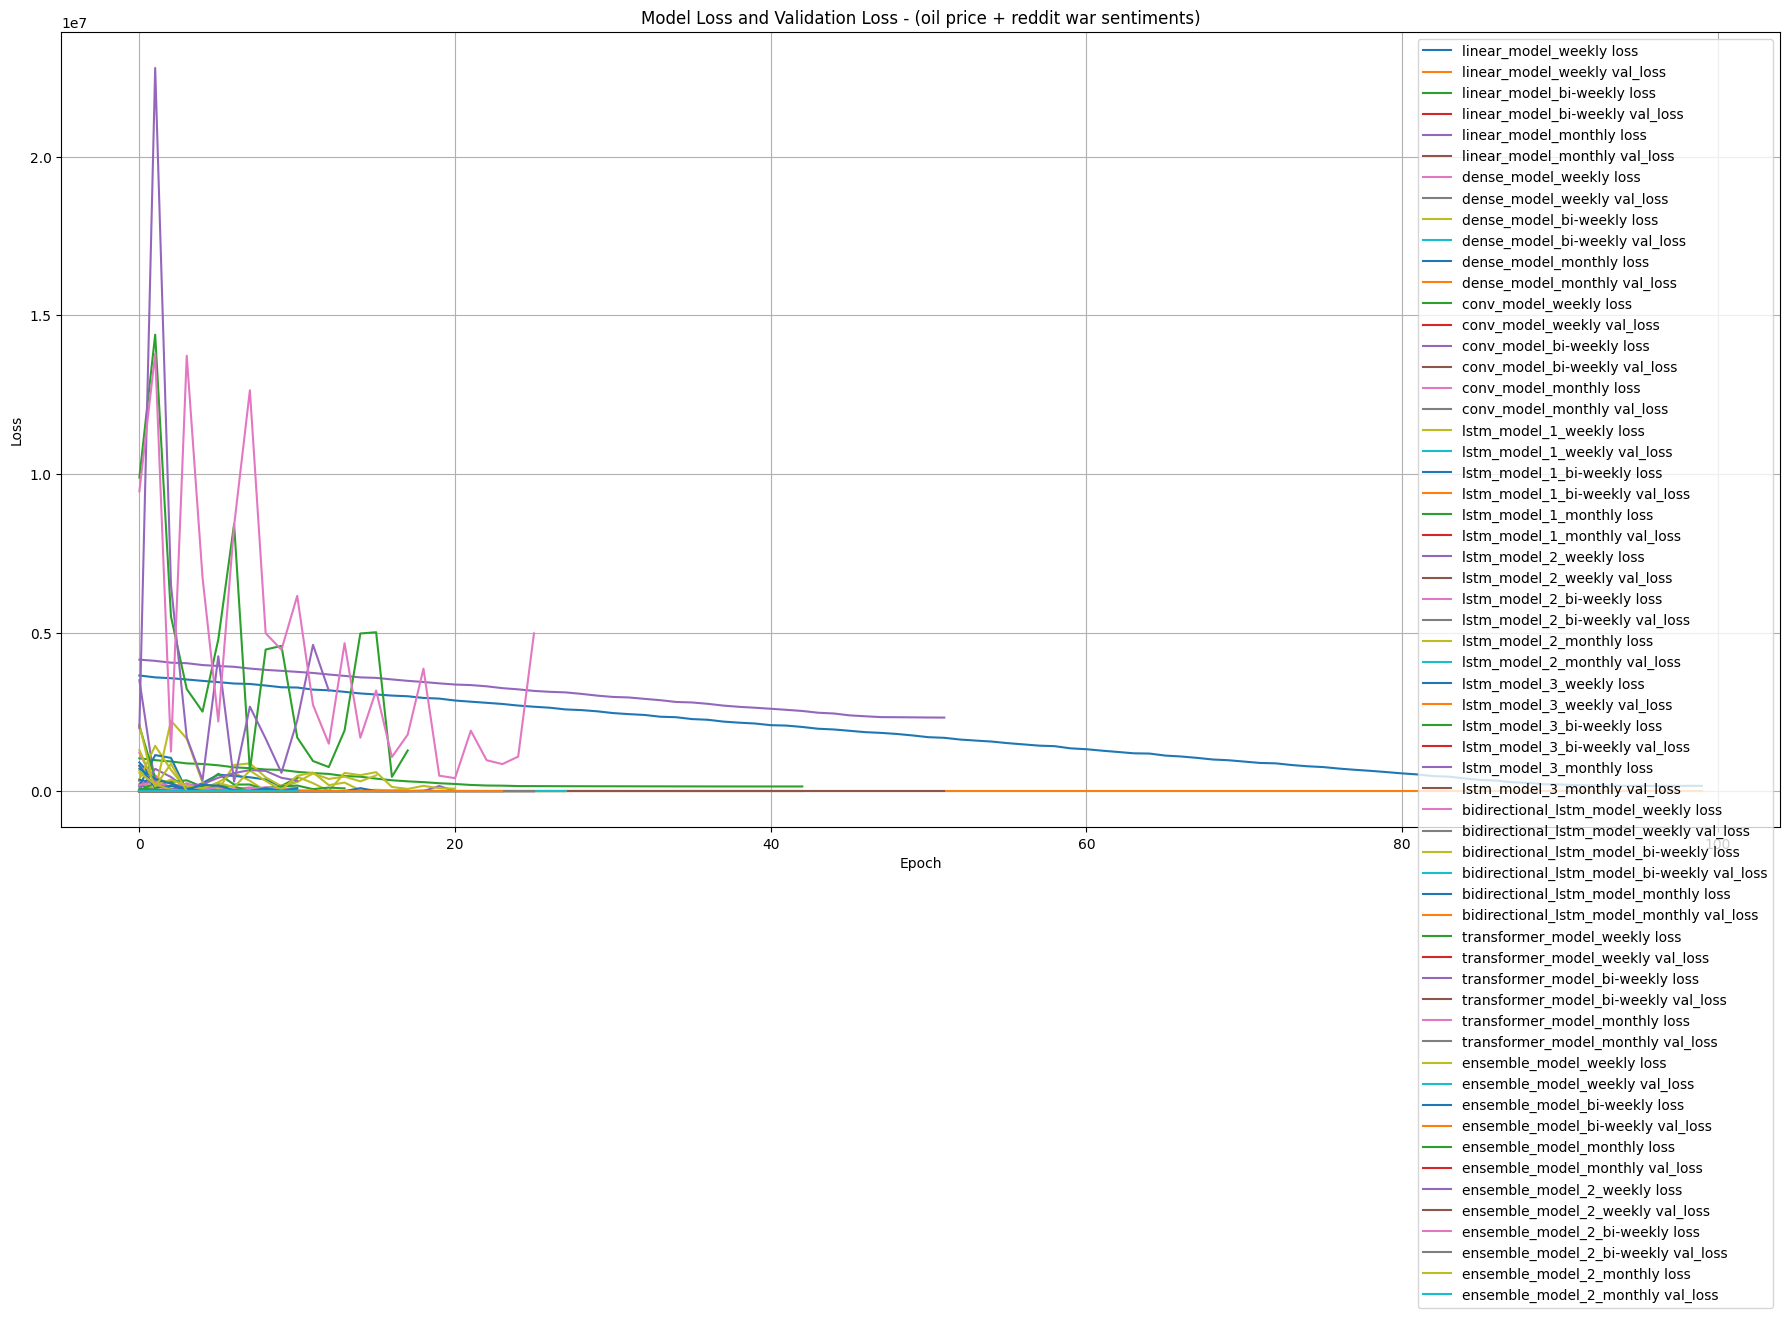

In [48]:
plt.figure(figsize=(18, 12))
for h in (histories):    # Plot Train vs Test Loss
    history=histories[h]
    plt.plot(history.history['loss'], label=f'{h} loss')
    plt.plot(history.history['val_loss'], label=f'{h} val_loss')

plt.title('Model Loss and Validation Loss - (oil price + reddit war sentiments)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs4/model loss all models (oil price + reddit war sentiments).png')

In [49]:
val_performance

{'linear_model_weekly': {'loss': 72.89871215820312,
  'mean_absolute_percentage_error': 72.89871215820312,
  'mean_squared_error': 0.09340815246105194},
 'linear_model_bi-weekly': {'loss': 113.81273651123047,
  'mean_absolute_percentage_error': 113.81273651123047,
  'mean_squared_error': 0.2208459973335266},
 'linear_model_monthly': {'loss': 38.71720504760742,
  'mean_absolute_percentage_error': 38.71720504760742,
  'mean_squared_error': 0.04352898150682449},
 'dense_model_weekly': {'loss': 71.36335754394531,
  'mean_absolute_percentage_error': 71.36335754394531,
  'mean_squared_error': 0.08426486700773239},
 'dense_model_bi-weekly': {'loss': 50.301509857177734,
  'mean_absolute_percentage_error': 50.301509857177734,
  'mean_squared_error': 0.05904591828584671},
 'dense_model_monthly': {'loss': 78.98464965820312,
  'mean_absolute_percentage_error': 78.98464965820312,
  'mean_squared_error': 0.1248592659831047},
 'conv_model_weekly': {'loss': 100.0,
  'mean_absolute_percentage_error': 1

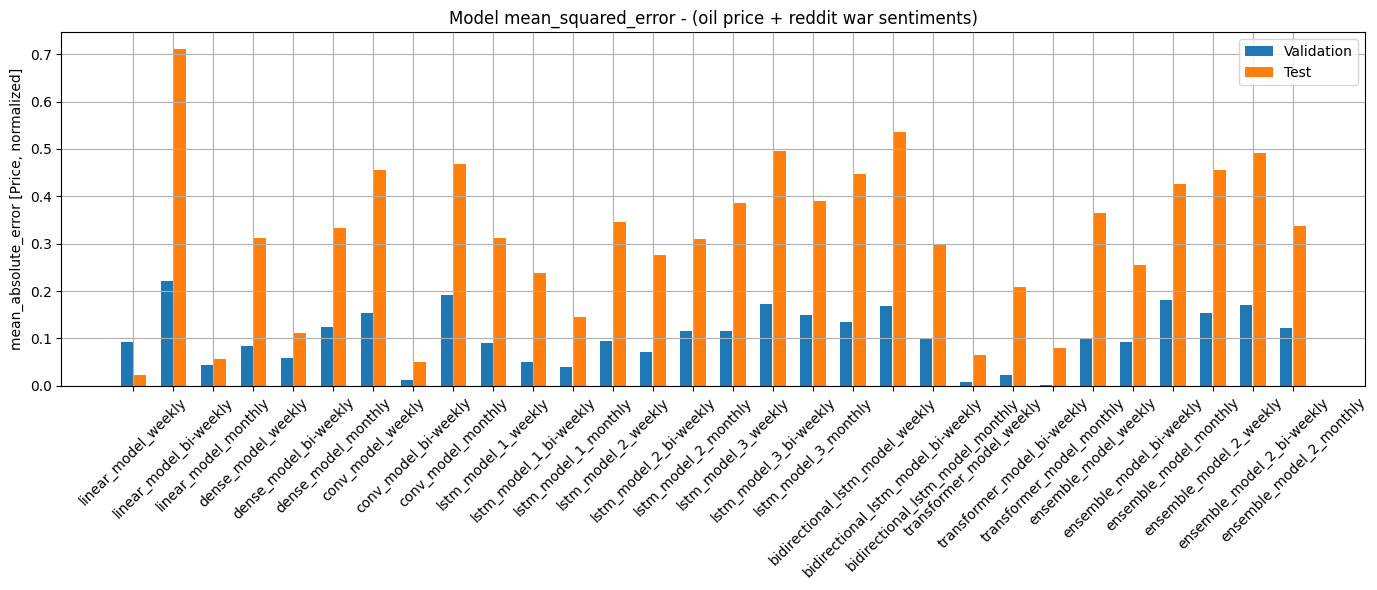

In [50]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.figure(figsize=(14, 6))
# plt.yscale('log')  # Set y-axis to log scale
plt.title('Model mean_squared_error - (oil price + reddit war sentiments)')
plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs4/mean_squared_error all models (oil price + reddit war sentiments).png')


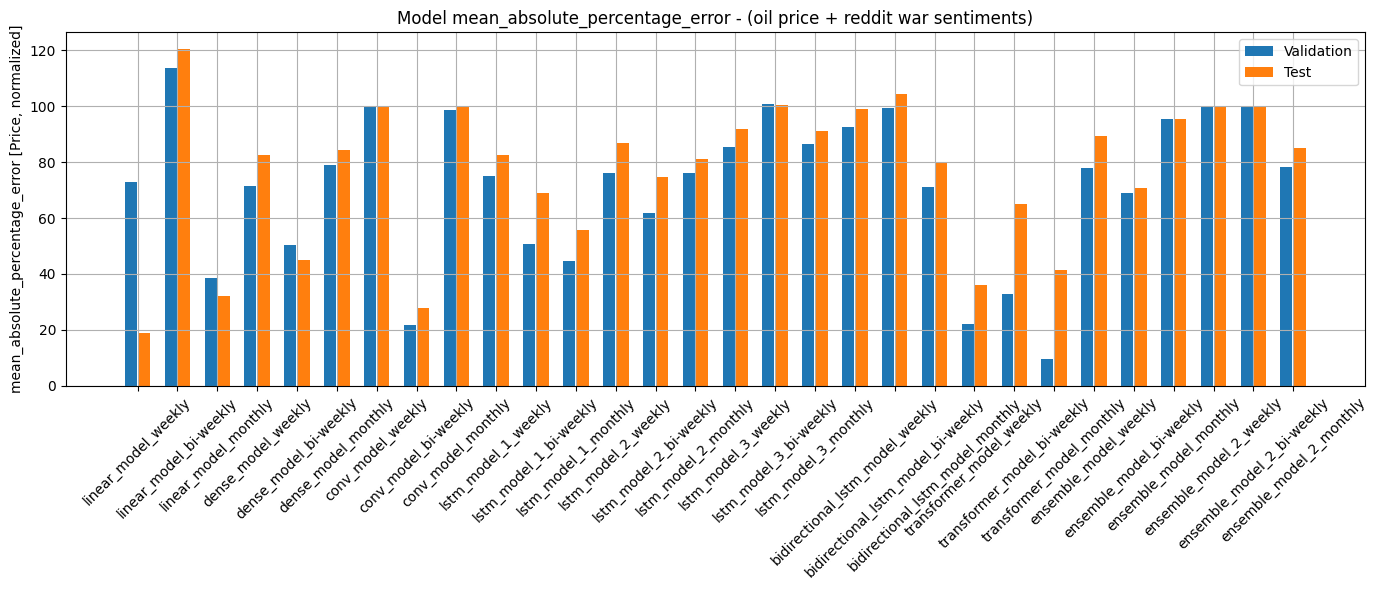

In [51]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
plt.figure(figsize=(14, 6))
# plt.yscale('log')  # Set y-axis to log scale
plt.title('Model mean_absolute_percentage_error - (oil price + reddit war sentiments)')
plt.ylabel('mean_absolute_percentage_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs4/mean_absolute_percentage_error all models (oil price + reddit war sentiments).png')

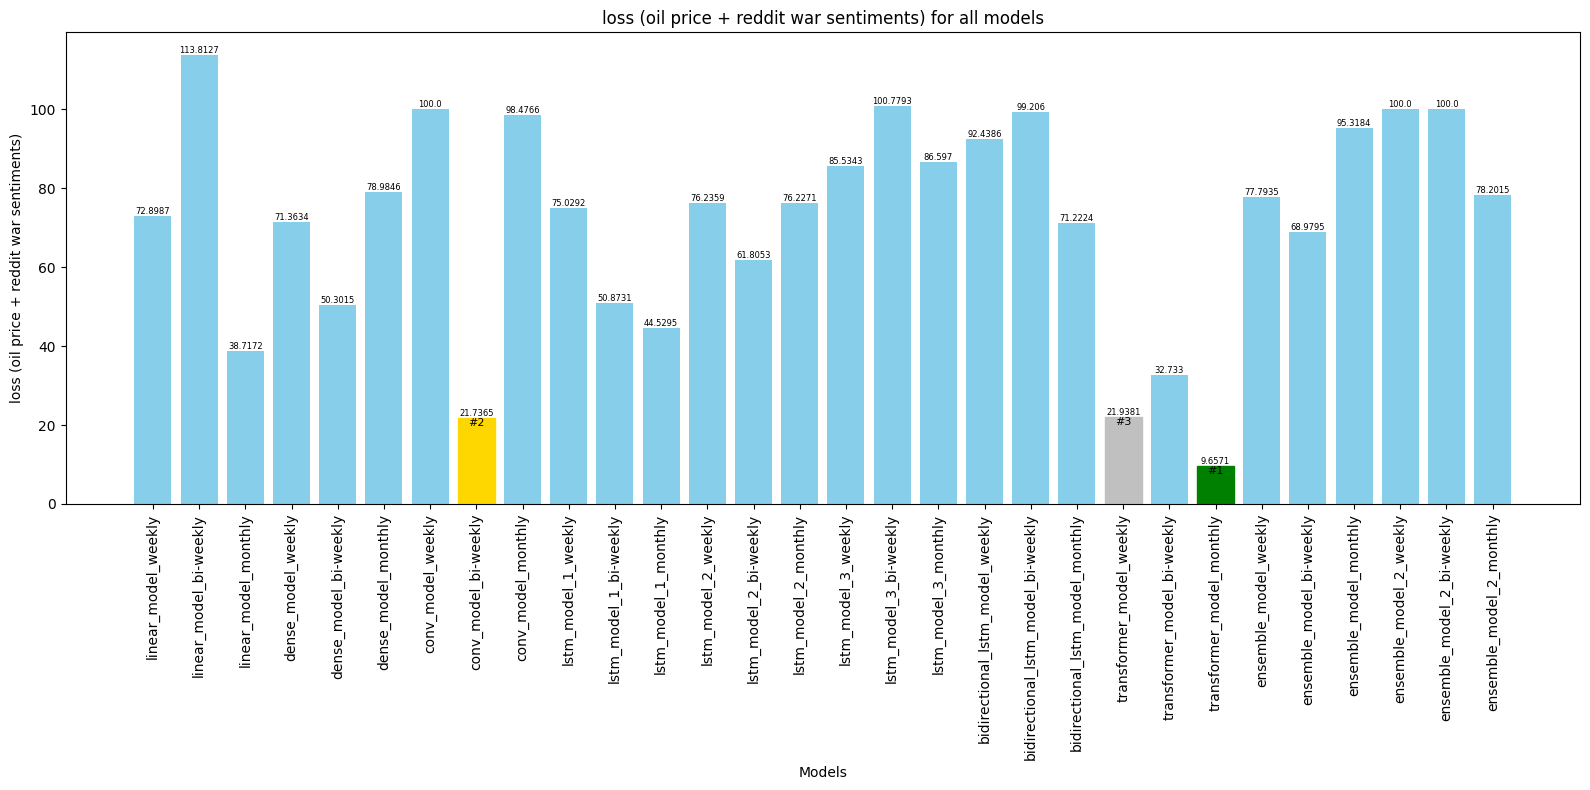

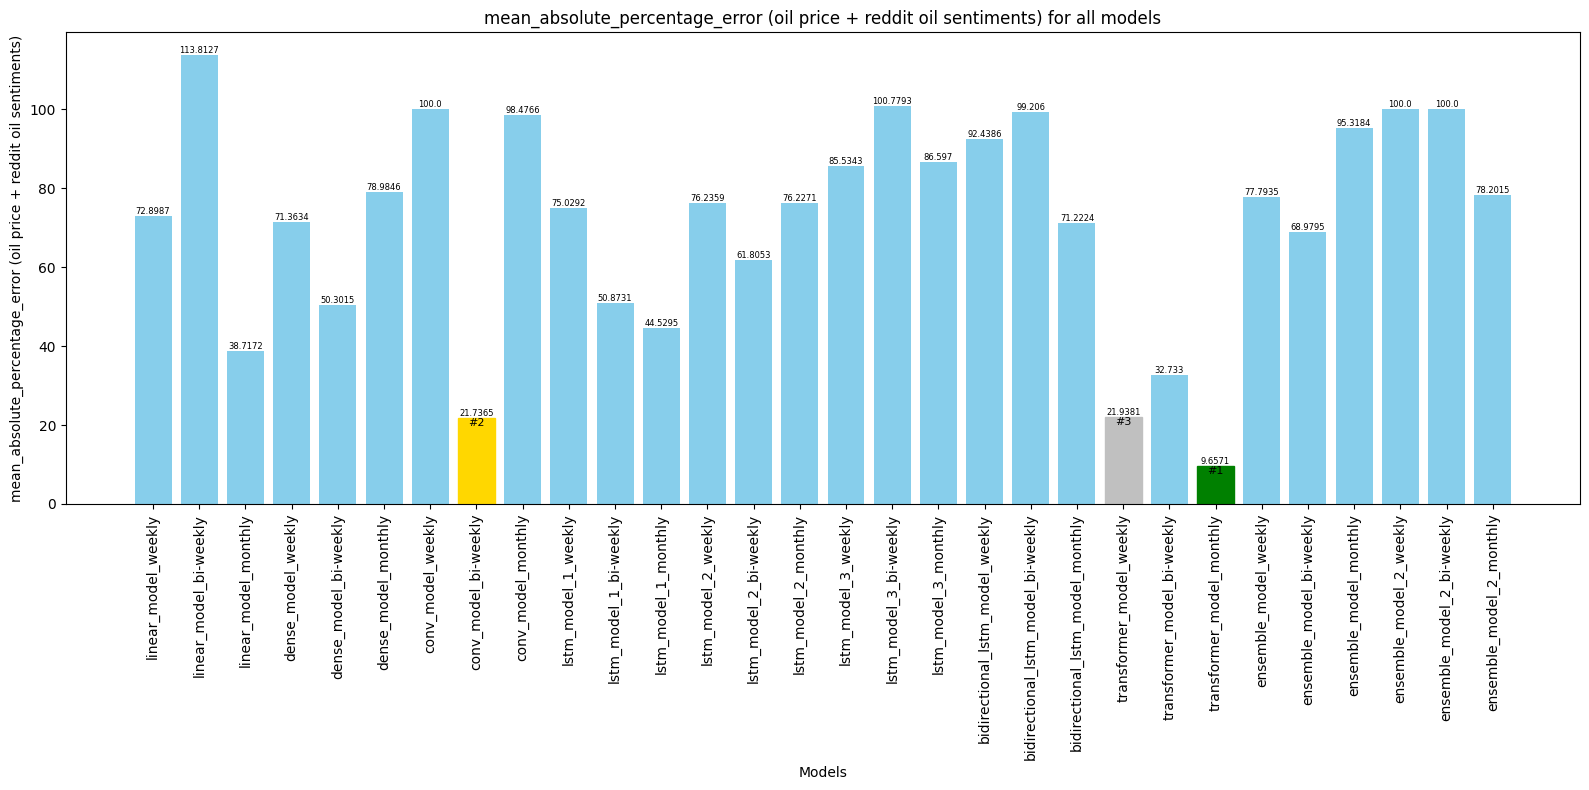

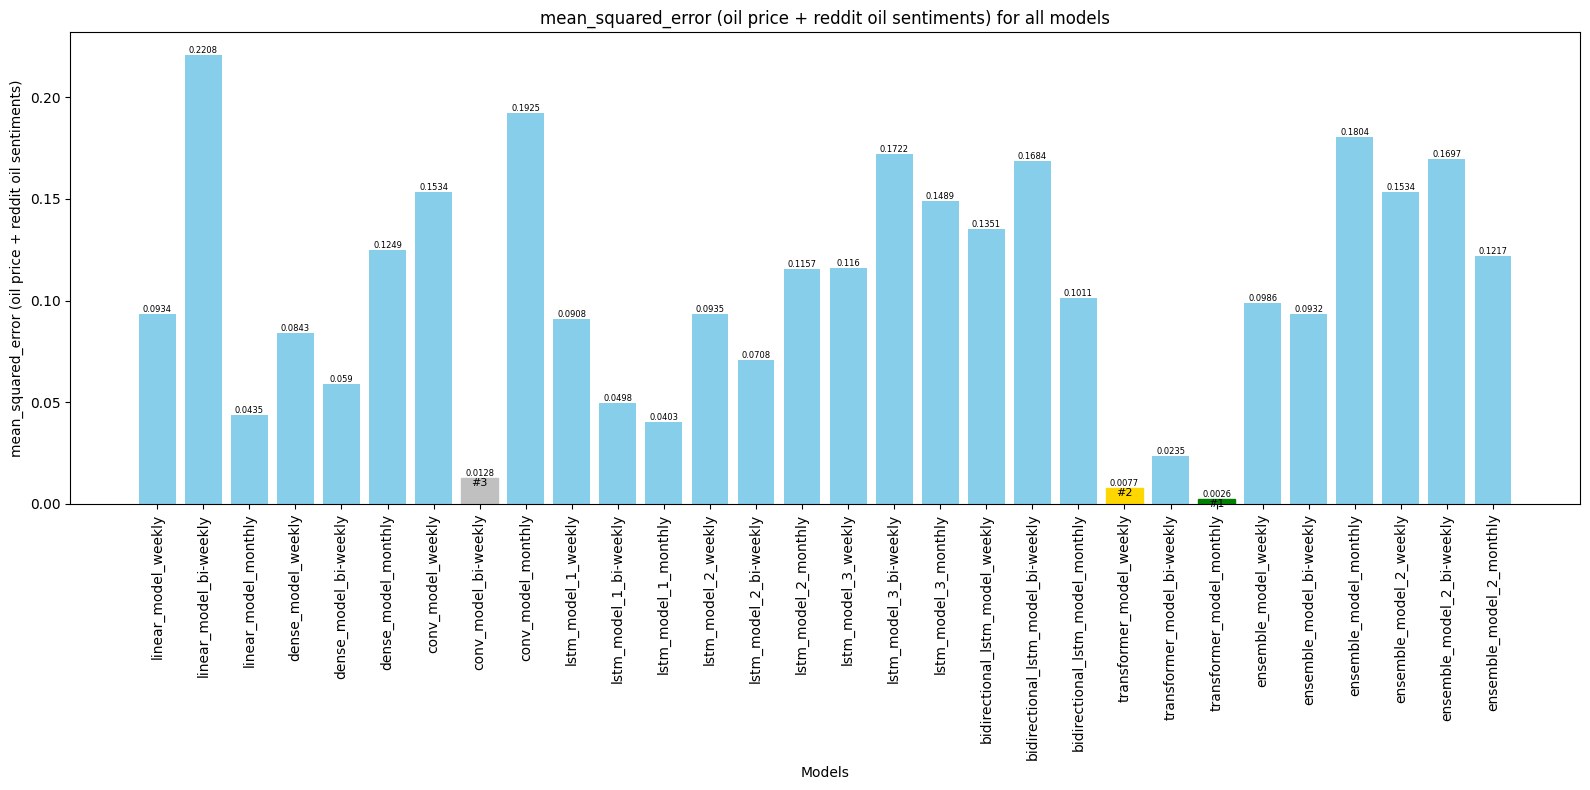

Top 3 models with minimum loss: ['transformer_model_monthly', 'conv_model_bi-weekly', 'transformer_model_weekly']
Top 3 models with minimum mean_absolute_error: ['transformer_model_monthly', 'conv_model_bi-weekly', 'transformer_model_weekly']
Top 3 models with minimum mean_squared_error: ['transformer_model_monthly', 'transformer_model_weekly', 'conv_model_bi-weekly']


In [52]:
# Extract data for each metric
models = list(val_performance.keys())
loss_values = [val_performance[model]['loss'] for model in models]
mae_values = [val_performance[model]['mean_absolute_percentage_error'] for model in models]
mse_values = [val_performance[model]['mean_squared_error'] for model in models]

# Function to plot and save a metric, highlighting the best model
def plot_and_save_metric(metric_values, metric_name, best_models_indices):
    plt.figure(figsize=(16, 8))
    bars = plt.bar(models, metric_values, color='skyblue')
    # plt.yscale('log')  # Set y-axis to log scale
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for all models')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Highlight the best models with different colors
    colors = ['green', 'gold', 'silver']
    for rank, index in enumerate(best_models_indices):
        bars[index].set_color(colors[rank])
        yval = bars[index].get_height()
        plt.text(bars[index].get_x() + bars[index].get_width()/2, yval, f'#{rank+1}', ha='center', va='top', fontsize=8, color='black')

    # Annotate all bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center',va='bottom', fontsize=6)

    plt.savefig(f'outputs4/{metric_name}_comparison (oil price + reddit war sentiments).png')
    plt.show()

# Find the indices of the top 3 models with the minimum values for each metric
top_n = 3

min_loss_indices = np.argsort(loss_values)[:top_n]
min_mae_indices = np.argsort(mae_values)[:top_n]
min_mse_indices = np.argsort(mse_values)[:top_n]
# Plot and save loss
plot_and_save_metric(loss_values, 'loss (oil price + reddit war sentiments)', min_loss_indices)

# Plot and save mean_absolute_error
plot_and_save_metric(mae_values, 'mean_absolute_percentage_error (oil price + reddit oil sentiments)', min_mae_indices)

# Plot and save mean_squared_error
plot_and_save_metric(mse_values, 'mean_squared_error (oil price + reddit oil sentiments)', min_mse_indices)

# Get the model names for the top 3 models
min_loss_models = [models[i] for i in min_loss_indices]
min_mae_models = [models[i] for i in min_mae_indices]
min_mse_models = [models[i] for i in min_mse_indices]

print(f'Top {top_n} models with minimum loss: {min_loss_models}')
print(f'Top {top_n} models with minimum mean_absolute_error: {min_mae_models}')
print(f'Top {top_n} models with minimum mean_squared_error: {min_mse_models}')